# Importing all important python libraries

In [1]:
# Downlaoding and importing important libraries
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import seaborn as sns

# Data Collection and Preprocessing

In [2]:
# Downloading stock data for 10 years of t0 global companies
company_list = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "META", "NFLX", "NVDA", "JPM", "V"]
data = {}
start_date = "2014-10-01"
end_date = "2024-10-31"

# Fetching data
for company in company_list:
    data[company] = yf.download(company, start=start_date, end=end_date)

# Combine all data into a single DataFrame
combined_data = pd.concat(
    {k: v["Adj Close"] for k, v in data.items()}, axis=1
).reset_index()
combined_data.columns = ["Date"] + company_list

# Ensure 'Date' is in datetime format and set as index
combined_data['Date'] = pd.to_datetime(combined_data['Date'])
combined_data.set_index('Date', inplace=True)

# Display the head of the combined data to check
print(combined_data.head())

# Check if the data is properly indexed
print(f"Data is indexed by: {combined_data.index}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                 AAPL       MSFT      GOOGL       AMZN       TSLA       META  \
Date                                                                           
2014-10-01  21.991463  39.166977  28.909914  15.873000  16.016001  76.320206   
2014-10-02  22.151114  39.047516  28.972261  15.920500  16.761333  76.848625   
2014-10-03  22.089031  39.329102  29.240097  16.136999  17.014000  77.207542   
2014-10-06  22.089031  39.329102  29.316408  16.110001  17.374666  77.327171   
2014-10-07  21.896118  38.851250  28.634096  15.849000  17.304667  76.060989   

                 NFLX      NVDA        JPM          V  
Date                                                   
2014-10-01  62.685715  0.436684  45.038181  48.859627  
2014-10-02  64.282860  0.434771  44.636116  48.792168  
2014-10-03  65.648567  0.435727  45.743675  49.320278  
2014-10-06  66.211426  0.433098  45.652641  49.273743  
2014-10-07  65.178574  0.428557  44.962315  48.403622  
Data is indexed by: DatetimeIndex(['2014-10-01'

In [3]:
for company in company_list:
    print(f"Head of {company} Stock Data:")
    print(data[company].head())
    print("\n")

Head of AAPL Stock Data:
Price       Adj Close      Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                                        
2014-10-01  21.991463  24.795000  25.172501  24.674999  25.147499  205965200
2014-10-02  22.151114  24.975000  25.055000  24.510000  24.817499  191031200
2014-10-03  22.089031  24.905001  25.052500  24.760000  24.860001  173878400
2014-10-06  22.089031  24.905001  25.162500  24.855000  24.987499  148204800
2014-10-07  21.896118  24.687500  25.030001  24.682501  24.857500  168376800


Head of MSFT Stock Data:
Price       Adj Close      Close       High        Low       Open    Volume
Ticker           MSFT       MSFT       MSFT       MSFT       MSFT      MSFT
Date                                                                       
2014-10-01  39.166977  45.900002  46.529999  45.849998  46.270000  38088400
2014-10-02  39.047516  45.75

In [4]:
# Calculating ADF test for checking non-stationarity of stock data for individual company
def perform_adf_test(series, stock_name):
    result = adfuller(series.dropna())  
    print(f"ADF Test for {stock_name}:")
    print(f"  ADF Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    print(f"  Critical Values:")
    for key, value in result[4].items():
        print(f"    {key}: {value:.4f}")
    print("  Stationary" if result[1] < 0.05 else "  Non-Stationary")
    print("-" * 40)
    
for stock in combined_data.columns:
    perform_adf_test(combined_data[stock], stock)


ADF Test for AAPL:
  ADF Statistic: 0.5383
  p-value: 0.9860
  Critical Values:
    1%: -3.4329
    5%: -2.8627
    10%: -2.5674
  Non-Stationary
----------------------------------------
ADF Test for MSFT:
  ADF Statistic: 1.0655
  p-value: 0.9949
  Critical Values:
    1%: -3.4330
    5%: -2.8627
    10%: -2.5674
  Non-Stationary
----------------------------------------
ADF Test for GOOGL:
  ADF Statistic: 0.3467
  p-value: 0.9794
  Critical Values:
    1%: -3.4330
    5%: -2.8627
    10%: -2.5674
  Non-Stationary
----------------------------------------
ADF Test for AMZN:
  ADF Statistic: -0.6613
  p-value: 0.8565
  Critical Values:
    1%: -3.4330
    5%: -2.8627
    10%: -2.5674
  Non-Stationary
----------------------------------------
ADF Test for TSLA:
  ADF Statistic: -1.1303
  p-value: 0.7028
  Critical Values:
    1%: -3.4330
    5%: -2.8627
    10%: -2.5674
  Non-Stationary
----------------------------------------
ADF Test for META:
  ADF Statistic: 1.1048
  p-value: 0.9953
 

# Cointegration Testing and Spread Calculation

In [5]:
# As all companies stock prices are non-stationary we can continue with co-integration
# Calculate p-values for all pairs
pairs = []
p_values = []
for i in range(len(company_list)):
    for j in range(i + 1, len(company_list)):
        stock1 = combined_data[company_list[i]].dropna()
        stock2 = combined_data[company_list[j]].dropna()
        _, p_value, _ = coint(stock1, stock2)
        if p_value < 0.05:
            pairs.append((company_list[i], company_list[j]))
            p_values.append(p_value)

selected_pairs = pd.DataFrame({"Pairs": pairs, "P-Value": p_values})
print("Selected Pairs with p-value < 0.05:")
print(selected_pairs.sort_values("P-Value"))

Selected Pairs with p-value < 0.05:
           Pairs   P-Value
1   (GOOGL, JPM)  0.039936
0  (MSFT, GOOGL)  0.046574


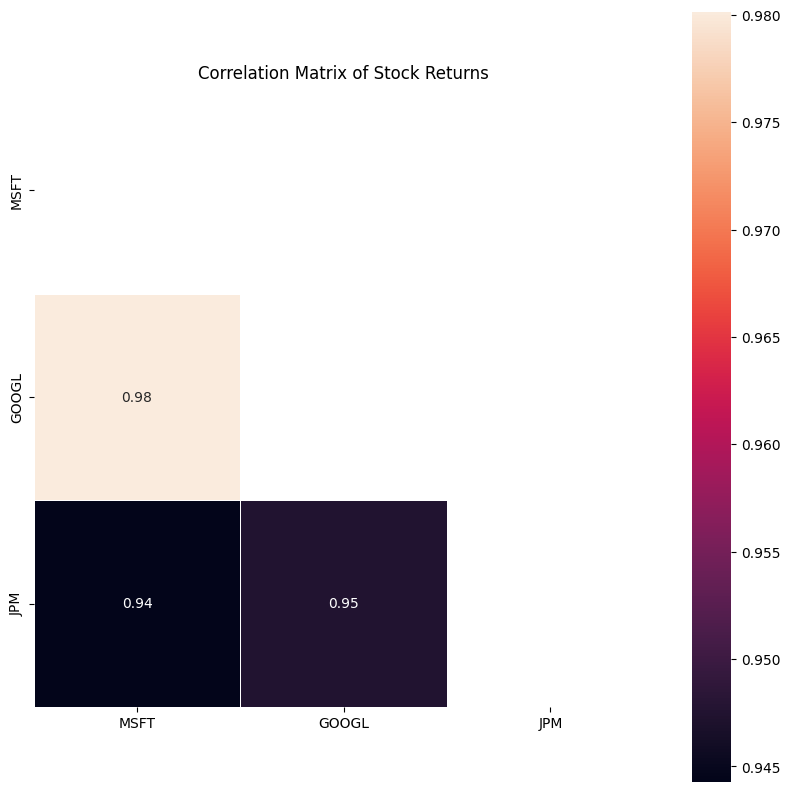

In [6]:
# Create return data for pairs
return_data = pd.DataFrame()
for pair in selected_pairs["Pairs"]:
    stock1 = pair[0]
    stock2 = pair[1]
    return_data[stock1] = combined_data[stock1].dropna()
    return_data[stock2] = combined_data[stock2].dropna()

# Calculate correlation matrix
corr = return_data.corr()

# Visualize correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, square=True, linewidths=0.5)
plt.title('Correlation Matrix of Stock Returns')
plt.show()


In [7]:
# Sort pairs by p-value to get the one with the lowest p-value
filtered_pairs = selected_pairs.sort_values(by="P-Value", ascending=True)

# Select the pair with the lowest p-value
best_pair = filtered_pairs.iloc[0]  

# Print the best pair and its p-value
print("Best Pair with the Lowest P-Value:")
print(best_pair)

# Prepare data for the selected pair
selected_data = {}
stock1, stock2 = best_pair["Pairs"]
selected_data[(stock1, stock2)] = {
    stock1: combined_data[stock1].dropna(),
    stock2: combined_data[stock2].dropna(),
}

Best Pair with the Lowest P-Value:
Pairs      (GOOGL, JPM)
P-Value        0.039936
Name: 1, dtype: object


Pair: ('GOOGL', 'JPM'), Beta: 0.9349


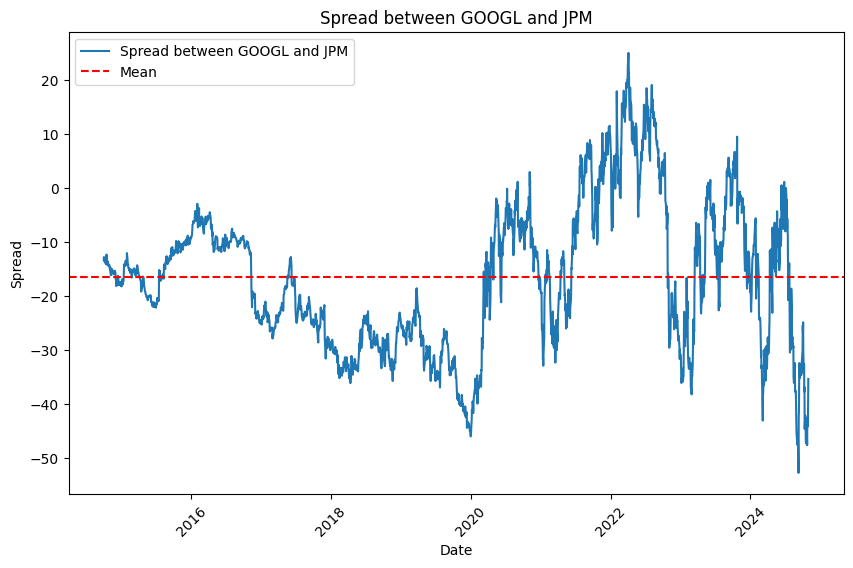

In [8]:
# Linear Regression to find beta and spread
spreads = {}
for pair, data in selected_data.items():
    stock1, stock2 = pair
    x = data[stock2].values.reshape(-1, 1)  
    y = data[stock1].values  

    
    model = LinearRegression()
    model.fit(x, y)
    beta = model.coef_[0]

    # Calculate the spread
    spreads[pair] = data[stock1] - beta * data[stock2]
    print(f"Pair: {pair}, Beta: {beta:.4f}")

best_pair = filtered_pairs.iloc[0] 
# Get the spread for the best pair
pair_to_plot = best_pair['Pairs']
spread = spreads[pair_to_plot]

# Plot the spread for the best pair
plt.figure(figsize=(10, 6))
plt.plot(spread.index, spread, label=f'Spread between {pair_to_plot[0]} and {pair_to_plot[1]}')
plt.axhline(spread.mean(), color='red', linestyle='--', label='Mean')
plt.legend()
plt.title(f'Spread between {pair_to_plot[0]} and {pair_to_plot[1]}')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.xticks(rotation=45)  
plt.show()


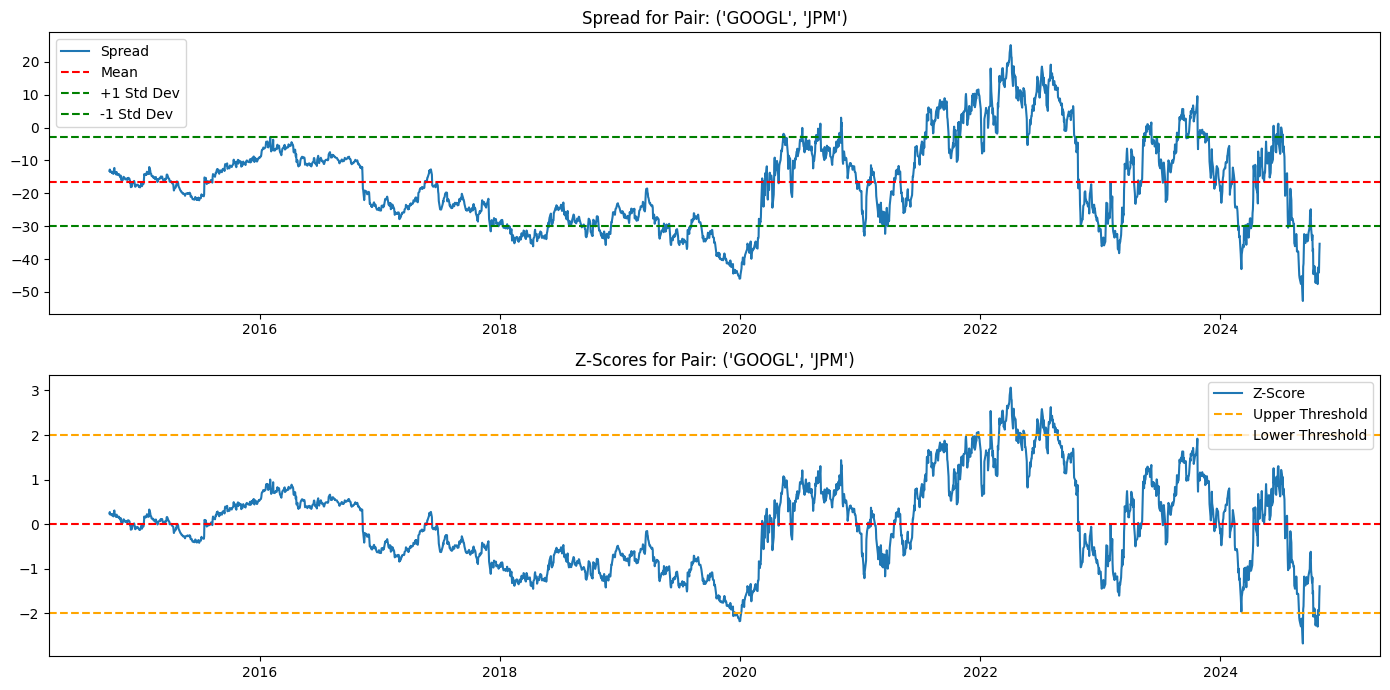

In [9]:
# Backtest results for one pair
pair_to_test = list(spreads.keys())[0] 
spread = spreads[pair_to_test]

# Calculate z-scores
spread_mean = spread.mean()
spread_std = spread.std()
z_scores = (spread - spread_mean) / spread_std

# Plot spread and z-scores
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(spread.index, spread, label="Spread")
plt.axhline(spread_mean, color="red", linestyle="--", label="Mean")
plt.axhline(spread_mean + spread_std, color="green", linestyle="--", label="+1 Std Dev")
plt.axhline(spread_mean - spread_std, color="green", linestyle="--", label="-1 Std Dev")
plt.legend()
plt.title(f"Spread for Pair: {pair_to_test}")

plt.subplot(2, 1, 2)
plt.plot(z_scores.index, z_scores, label="Z-Score")
plt.axhline(0, color="red", linestyle="--")
plt.axhline(2, color="orange", linestyle="--", label="Upper Threshold")
plt.axhline(-2, color="orange", linestyle="--", label="Lower Threshold")
plt.legend()
plt.title(f"Z-Scores for Pair: {pair_to_test}")
plt.tight_layout()
plt.show()

In [10]:
print(f"Spread Mean: {spread_mean}")
print(f"Spread Standard Deviation: {spread_std}")
print(f"Z-Scores Mean: {z_scores.mean()}")
print("Z-Score Summary:")
print(z_scores.describe())
print("Spread Summary:")
print(spread.describe())


Spread Mean: -16.458283680697786
Spread Standard Deviation: 13.56740240571989
Z-Scores Mean: -8.958773658125771e-17
Z-Score Summary:
count    2.538000e+03
mean    -8.958774e-17
std      1.000000e+00
min     -2.675553e+00
25%     -7.589937e-01
50%     -1.313545e-02
75%      6.340992e-01
max      3.062670e+00
dtype: float64
Spread Summary:
count    2538.000000
mean      -16.458284
std        13.567402
min       -52.758585
25%       -26.755857
50%       -16.636498
75%        -7.855204
max        25.094194
dtype: float64


# Backtesting Framework

In [44]:
# Backtesting with static threshold and risk management stop-loss and transaction cost

# Define parameters
transaction_cost = 0.0005  # 0.1% transaction cost
initial_capital = 100000 # 100000 initial capital
stop_loss_threshold = 0.90  # Stop trading if capital drops below 90% of initial
entry_threshold = 1 # Fixed entry threshold
exit_threshold = 0.5 # Fixed exit threshold

# Initialize variables
capital = initial_capital
position = 0
profits = [0] * len(spread)
positions = [0] * len(spread)

# Backtesting loop
for i in range(1, len(z_scores)):
    if capital < initial_capital * stop_loss_threshold:
        print(f"Stop-loss triggered. Ending trading at index {i}.")
        break

    if position == 0:
        if z_scores.iloc[i] > entry_threshold:
            position = -1  # Short spread
            entry_price = spread.iloc[i]
        elif z_scores.iloc[i] < -entry_threshold:
            position = 1  # Long spread
            entry_price = spread.iloc[i]

    elif position != 0:
        if abs(z_scores.iloc[i]) < exit_threshold:
            exit_price = spread.iloc[i]
            profit = (exit_price - entry_price) * position
            transaction_fee = transaction_cost * abs(profit)
            profit -= transaction_fee
            capital += profit
            profits[i] = profit
            position = 0  # Reset position
        else:
            profits[i] = 0  # No realized profit/loss
    positions[i] = position

# Results of Backtest
backtest_results = pd.DataFrame({
    'Spread': spread,
    'Z-Score': z_scores,
    'Position': positions,
    'Cumulative Profit': np.cumsum(profits),
})

# Performance Metrics
cumulative_profit = backtest_results['Cumulative Profit'].iloc[-1]
daily_returns = np.diff(backtest_results['Cumulative Profit'], prepend=0) / initial_capital
# Sharpe Ratio
sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252) if daily_returns.std() > 0 else 0

print("Daily Returns Distribution:")
print(pd.Series(daily_returns).describe())

Daily Returns Distribution:
count    2538.000000
mean        0.000002
std         0.000007
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.000071
dtype: float64


Cumulative Profit: 443.15
Sharpe Ratio: 4.23


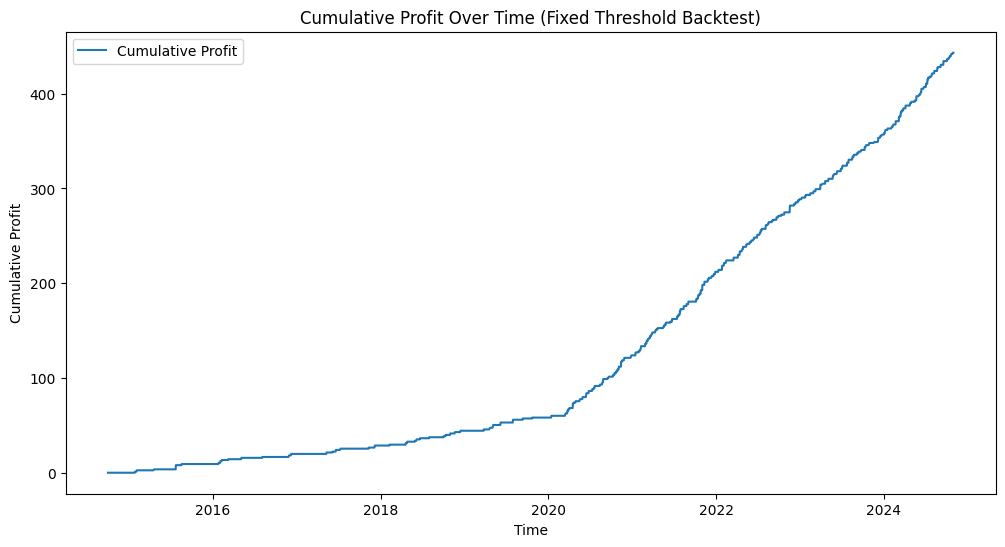

In [45]:
print(f"Cumulative Profit: {cumulative_profit:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(backtest_results.index, backtest_results['Cumulative Profit'], label='Cumulative Profit')
plt.title('Cumulative Profit Over Time (Fixed Threshold Backtest)')
plt.xlabel('Time')
plt.ylabel('Cumulative Profit')
plt.legend()
plt.show()

In [49]:
# Print performance metrics
print(f"Final Capital: {capital:.2f}")
print(f"Total Trades: {sum(p != 0 for p in profits)}")
print(f"Average Profit per Trade: {np.mean([p for p in profits if p != 0]):.2f}")

Final Capital: 100443.15
Total Trades: 204
Average Profit per Trade: 2.17


# Applying Monte Carlo Simulations with same parameters

In [46]:
# Now using Monte Carlo simulation
# Define transaction cost and backtesting parameters
transaction_cost = 0.0005
entry_threshold = 1.0
exit_threshold = 0.5
initial_capital = 100000
stop_loss_threshold = 0.95
# Function to simulate one run of the strategy
def simulate_strategy(spread, z_scores, entry_threshold, exit_threshold, transaction_cost, initial_capital):
    capital = initial_capital
    position = 0
    profits = [0] * len(spread)
    positions = [0] * len(spread)

    for i in range(1, len(z_scores)):
        # Check if we're in a trade
        if capital < initial_capital * stop_loss_threshold:
            print(f"Stop-loss triggered. Ending trading at index {i}.")
            break
        if position == 0:
            # Enter trade
            if z_scores.iloc[i] > entry_threshold:
                position = -1  # Short the spread
                entry_price = spread.iloc[i]
            elif z_scores.iloc[i] < -entry_threshold:
                position = 1  # Long the spread
                entry_price = spread.iloc[i]
        elif position != 0:
            # Exit trade
            if abs(z_scores.iloc[i]) < exit_threshold:
                exit_price = spread.iloc[i]
                profit = (exit_price - entry_price) * position
                # Subtract transaction cost
                transaction_fee = transaction_cost * abs(profit)  # Fee based on trade size
                profit -= transaction_fee
                capital += profit
                profits[i] = profit
                position = 0  # Exit position
            else:
                profits[i] = 0  # No profit/loss if trade remains open

        positions[i] = position  # Store the position at the correct index

    return np.cumsum(profits)  # Return cumulative profit

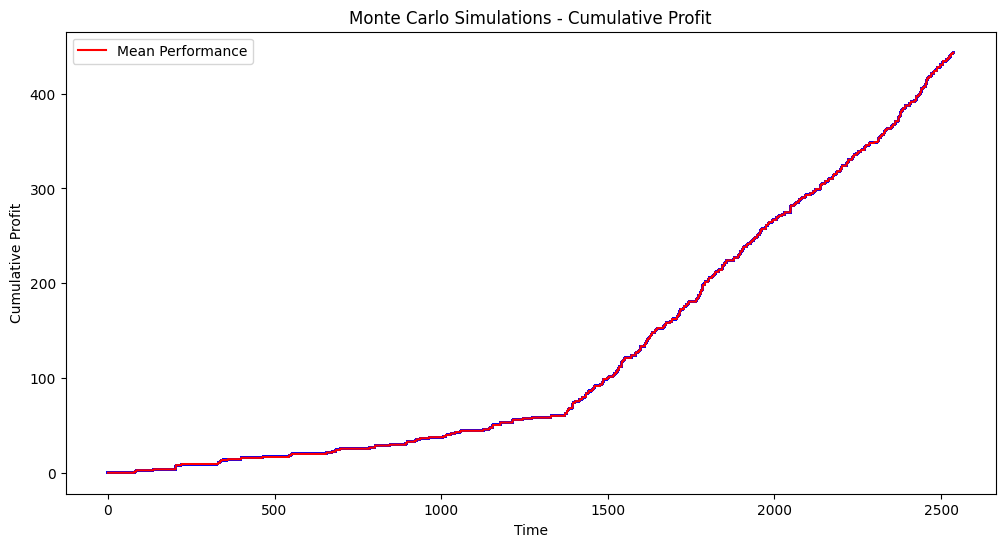

Monte Carlo Mean Cumulative Profit: 443.15
Monte Carlo Sharpe Ratio: 4.23


In [48]:
# Monte Carlo simulation to run multiple simulations
def monte_carlo_simulation(spread, z_scores, num_simulations=1000, entry_threshold=1.0, exit_threshold=0.5, transaction_cost=0.0005, initial_capital=100000):
    results = []
    
    for _ in range(num_simulations):
        result = simulate_strategy(spread, z_scores, entry_threshold, exit_threshold, transaction_cost, initial_capital)
        results.append(result)
    
    # Convert the list of results to a numpy array for easier analysis
    results = np.array(results)
    return results
# random_spread = spread + np.random.normal(0, spread.std() * 0.1, len(spread))
#random_z_scores = z_scores + np.random.normal(0, z_scores.std() * 0.1, len(z_scores))


# Run Monte Carlo simulation with 1000 iterations
simulated_results = monte_carlo_simulation(spread, z_scores)

# Calculate the performance metrics for each simulation
mean_results = simulated_results.mean(axis=0)
std_results = simulated_results.std(axis=0)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(simulated_results.T, color='blue', alpha=0.1)  
plt.plot(mean_results, color='red', label='Mean Performance')
plt.title('Monte Carlo Simulations - Cumulative Profit')
plt.xlabel('Time')
plt.ylabel('Cumulative Profit')
plt.legend()
plt.show()

# Performance metrics for Monte Carlo simulations
mean_cumulative_profit = mean_results[-1]
std_cumulative_profit = std_results[-1]

# Sharpe ratio based on the mean and standard deviation of simulated returns
mean_daily_returns = np.diff(mean_results) / initial_capital
sharpe_ratio_monte_carlo = mean_daily_returns.mean() / mean_daily_returns.std() * np.sqrt(252) if mean_daily_returns.std() > 0 else 0

print(f"Monte Carlo Mean Cumulative Profit: {mean_cumulative_profit:.2f}")
print(f"Monte Carlo Sharpe Ratio: {sharpe_ratio_monte_carlo:.2f}")

In [29]:
''' final_profits = simulated_results[:, -1]
    plt.hist(final_profits, bins=50, alpha=0.7)
    plt.xlabel('Final Cumulative Profit')
    plt.ylabel('Frequency')
    plt.title('Distribution of Final Profits Across Monte Carlo Simulations')
    plt.show()
'''
# Sharpe ratio

" final_profits = simulated_results[:, -1]\n    plt.hist(final_profits, bins=50, alpha=0.7)\n    plt.xlabel('Final Cumulative Profit')\n    plt.ylabel('Frequency')\n    plt.title('Distribution of Final Profits Across Monte Carlo Simulations')\n    plt.show()\n"

In [430]:
# Print performance metrics
print(f"Final Capital: {capital:.2f}")
print(f"Total Trades: {sum(p != 0 for p in profits)}")
print(f"Average Profit per Trade: {np.mean([p for p in profits if p != 0]):.2f}")

Final Capital: 100222.72
Total Trades: 26
Average Profit per Trade: 8.57


# Predicting Spreads Using LSTM

In [ ]:
# Importing necessary libraries
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

if isinstance(spread, pd.Series):
    spread = spread.values  
# Ensure the spread data is a 1D array
spread = spread.flatten()

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
spread_normalized = scaler.fit_transform(spread.reshape(-1, 1))

# Prepare the dataset for LSTM
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Define the time step
time_steps = 60

# Create sequences
X, y = create_sequences(spread_normalized, time_steps)

# Debugging: Check shapes
print(f"Shape of X (LSTM Input): {X.shape}")
print(f"Shape of y (Target): {y.shape}")

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Debugging: Check shapes after split
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X (LSTM Input): (2478, 60, 1)
Shape of y (Target): (2478, 1)
Shape of X_train: (1982, 60, 1)
Shape of X_test: (496, 60, 1)
Shape of y_train: (1982, 1)
Shape of y_test: (496, 1)


In [31]:
# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), verbose=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions and targets to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

C:\Users\yashy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - loss: 0.0705 - val_loss: 0.0069
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0039 - val_loss: 0.0061
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0034 - val_loss: 0.0057
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0037 - val_loss: 0.0053
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0032 - val_loss: 0.0051
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0031 - val_loss: 0.0048
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0027 - val_loss: 0.0057
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0028 - val_loss: 0.0048
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0024 - val_loss: 0.0041
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/ste

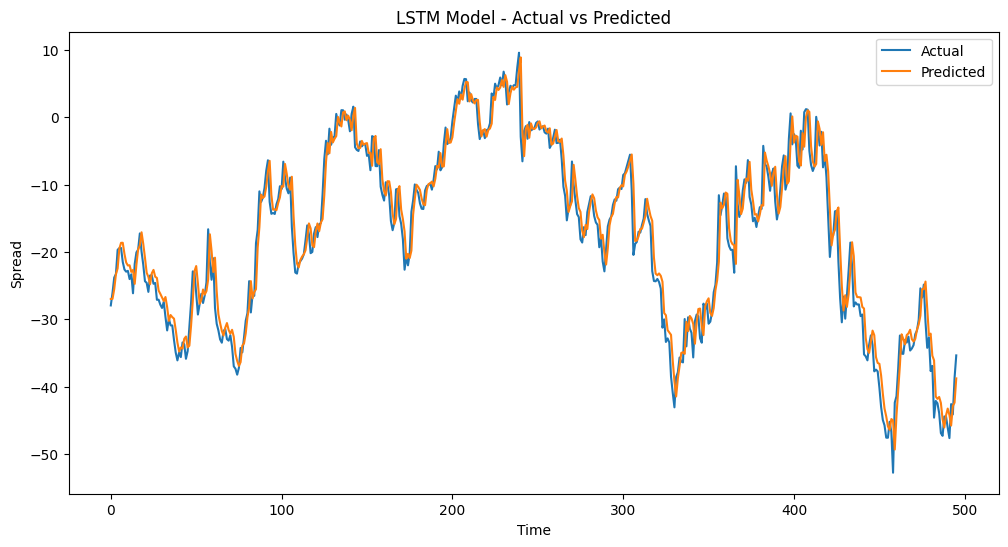

In [32]:
# Plotting and analyzing the trained lstm model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test_original, test_predict)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, test_predict)
r2 = r2_score(y_test_original, test_predict)

# Plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Actual")
plt.plot(test_predict, label="Predicted")
plt.title("LSTM Model - Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("Spread")
plt.legend()
plt.show()

In [33]:
# Evaluate model performance
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Squared Error (MSE): 8.8738
Root Mean Squared Error (RMSE): 2.9789
Mean Absolute Error (MAE): 2.2187
R-squared (R²): 0.9500


In [34]:
# Predicting next day spread through our trained model
last_sequence = X_test[-1]  # Take the last sequence from X_test
last_sequence = last_sequence.reshape((1, time_steps, 1))
# Predict the next value
next_day_prediction = model.predict(last_sequence)
# Inverse transform the prediction back to the original scale
next_day_prediction_original = scaler.inverse_transform(next_day_prediction)
# Print the predicted spread for the next day
print(f"Predicted Spread for the Next Day: {next_day_prediction_original[0][0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted Spread for the Next Day: -38.76139831542969


# Dynamic Hedging Using Kalman Filters

In [259]:
pip install pykalman

Note: you may need to restart the kernel to use updated packages.


In [35]:
from pykalman import KalmanFilter

# Define the Kalman Filter function
def kalman_filter_estimation(stock1, stock2):
    """
    Apply the Kalman Filter to estimate beta and spread dynamically over time.
    :param stock1: Time series of stock1 prices (dependent variable).
    :param stock2: Time series of stock2 prices (independent variable).
    :return: Estimated beta, spread, and residuals.
    """
    n = len(stock1)
    # Design the observation matrix
    # The observation model: y_t = beta_t * x_t + noise
    delta = 1e-5  # Transition noise
    trans_cov = delta / (1 - delta) * np.eye(2)  # State covariance matrix
    
    # Observation matrix (for y_t = beta_t * x_t + intercept + noise)
    obs_mat = np.vstack([stock2, np.ones(n)]).T.reshape(n, 1, 2)
    
    # Initialize the Kalman Filter
    kf = KalmanFilter(
        n_dim_obs=1,  # Single observation: stock1
        n_dim_state=2,  # Two states: beta and intercept
        transition_matrices=np.eye(2),  # State transition is identity
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov,
        initial_state_mean=[0, 0],  
        initial_state_covariance=np.eye(2) * 0.1,
    )
    
    # Use the Kalman Filter to estimate beta and intercept dynamically
    state_means, state_covs = kf.filter(stock1.values.reshape(-1, 1))
    
    # Extract beta and intercept
    beta = state_means[:, 0]
    intercept = state_means[:, 1]
    
    # Calculate spread: spread = stock1 - (beta * stock2 + intercept)
    spread = stock1 - (beta * stock2 + intercept)
    
    return beta, intercept, spread

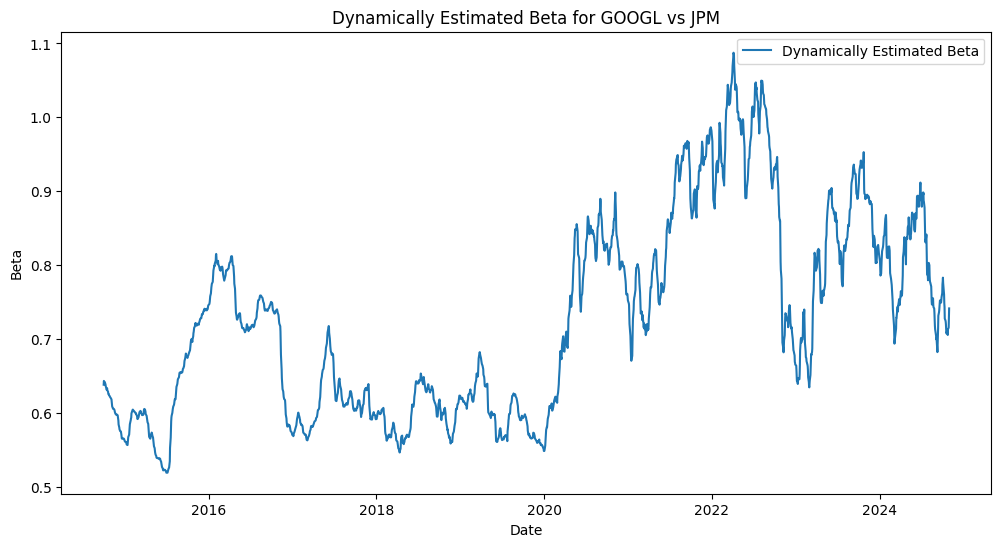

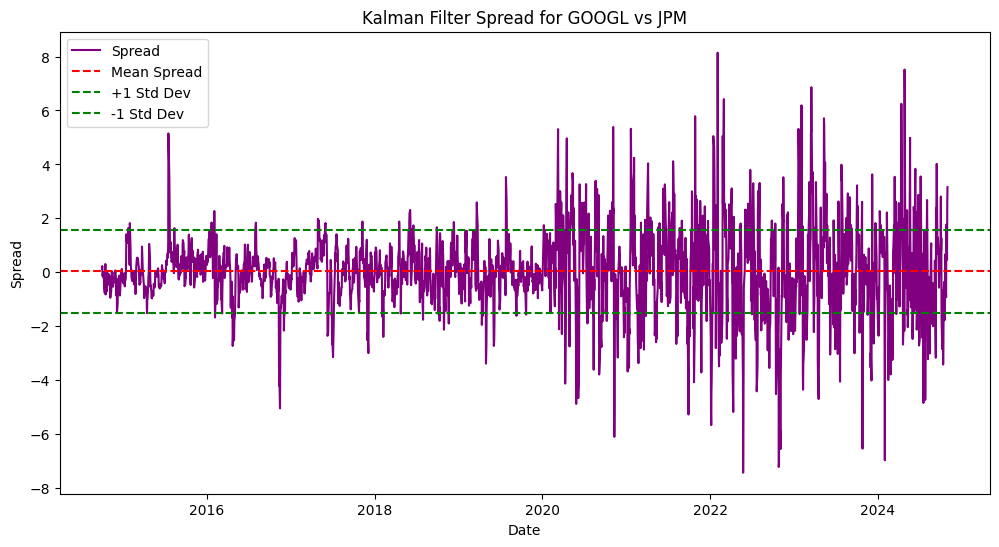

Spread Summary Statistics:
count    2538.000000
mean        0.030958
std         1.538984
min        -7.431323
25%        -0.660081
50%         0.032791
75%         0.773319
max         8.140447
dtype: float64
Z_scores Summary Statistics:
count    2.538000e+03
mean    -1.399808e-17
std      1.000000e+00
min     -4.848835e+00
25%     -4.490228e-01
50%      1.191118e-03
75%      4.823704e-01
max      5.269377e+00
dtype: float64


In [37]:
# Example usage with the best pair of stocks
stock1_name, stock2_name = best_pair["Pairs"]
stock1_data = combined_data[stock1_name].dropna()
stock2_data = combined_data[stock2_name].dropna()

# Align data
aligned_data = pd.concat([stock1_data, stock2_data], axis=1).dropna()
stock1_aligned = aligned_data.iloc[:, 0]
stock2_aligned = aligned_data.iloc[:, 1]

# Apply Kalman Filter to estimate beta and spread
beta, intercept, spread = kalman_filter_estimation(stock1_aligned, stock2_aligned)

# Plot the dynamically estimated beta
plt.figure(figsize=(12, 6))
plt.plot(stock1_aligned.index, beta, label="Dynamically Estimated Beta")
plt.title(f"Dynamically Estimated Beta for {stock1_name} vs {stock2_name}")
plt.xlabel("Date")
plt.ylabel("Beta")
plt.legend()
plt.show()

# Plot the spread
plt.figure(figsize=(12, 6))
plt.plot(stock1_aligned.index, spread, label="Spread", color="purple")
plt.axhline(spread.mean(), color="red", linestyle="--", label="Mean Spread")
plt.axhline(spread.mean() + spread.std(), color="green", linestyle="--", label="+1 Std Dev")
plt.axhline(spread.mean() - spread.std(), color="green", linestyle="--", label="-1 Std Dev")
plt.title(f"Kalman Filter Spread for {stock1_name} vs {stock2_name}")
plt.xlabel("Date")
plt.ylabel("Spread")
plt.legend()
plt.show()
spread_mean = spread.mean()
spread_std = spread.std()
# Z_scores
z_scores = (spread - spread_mean) / spread_std

# Print summary statistics for spread
print("Spread Summary Statistics:")
print(spread.describe())
print("Z_scores Summary Statistics:")
print(z_scores.describe())


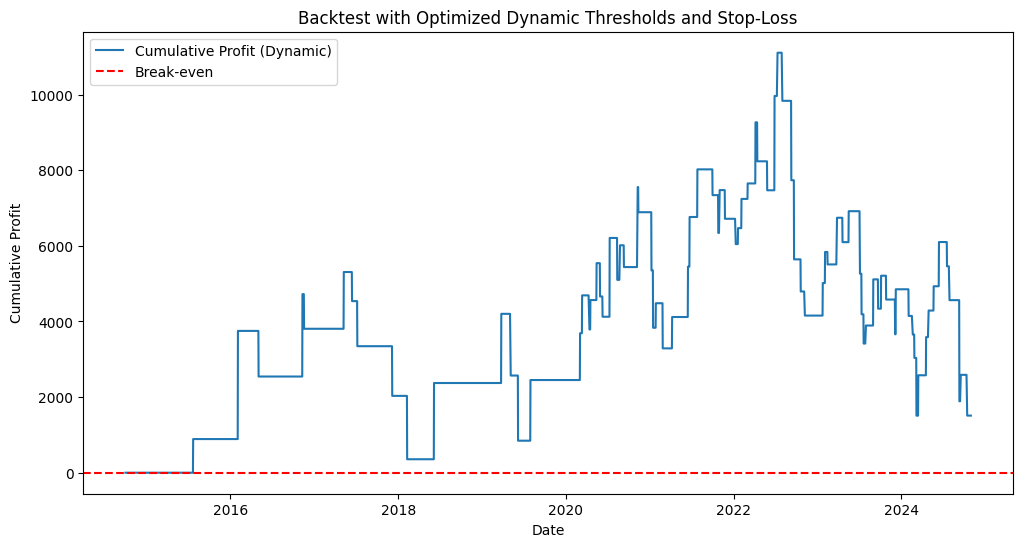

In [42]:
# Parameters derived from spread statistics
initial_capital = 100000  # Starting capital
position_size_percentage = 0.02  # 2% capital per trade
rolling_window = 20  # Rolling window for spread volatility
entry_base = 1.0 * z_scores.std()  # Base entry threshold (scaled by std)
exit_base = 0.5 * z_scores.std()  # Base exit threshold (scaled by std)
volatility_scaling_factor = 1.0  # Entry threshold scaling factor
dynamic_stop_loss_factor = 1  # Stop-loss scaled by rolling spread std
dynamic_transaction_cost_factor = 0.0005  # Transaction cost proportional to profit

# Initialize variables
capital = initial_capital
position = 0
profits = np.zeros(len(spread))
positions = np.zeros(len(spread))

# Pre-compute rolling volatility
spread_volatility = spread.rolling(window=rolling_window).std()

# Backtesting with dynamic adjustments
for i in range(rolling_window, len(z_scores)):
    trade_size = capital * position_size_percentage / spread_volatility.iloc[i]

    # Dynamic thresholds based on rolling Z-score volatility
    z_volatility = z_scores.iloc[i - rolling_window:i].std()
    entry_threshold = entry_base + z_volatility * volatility_scaling_factor
    exit_threshold = exit_base + z_volatility * 0.5

    # Dynamic stop-loss based on rolling spread volatility
    stop_loss = dynamic_stop_loss_factor * spread_volatility.iloc[i] * trade_size

    if position == 0:  # No active position
        if z_scores.iloc[i] > entry_threshold:
            position = -1  # Short the spread
            entry_price = spread.iloc[i]
        elif z_scores.iloc[i] < -entry_threshold:
            position = 1  # Long the spread
            entry_price = spread.iloc[i]
    elif position != 0: 
        unrealized_pnl = position * (spread.iloc[i] - entry_price) * trade_size / entry_price

        # Exit trade if spread reverts or stop-loss is hit
        if abs(z_scores.iloc[i]) < exit_threshold or abs(unrealized_pnl) > stop_loss:
            exit_price = spread.iloc[i]
            profit = position * (exit_price - entry_price) * trade_size / entry_price
            transaction_fee = dynamic_transaction_cost_factor * abs(profit)
            profit -= transaction_fee  
            capital += profit
            profits[i] = profit  
            position = 0  
        else:
            profits[i] = 0 

    positions[i] = position  

# Calculate cumulative profit
cumulative_profit = np.cumsum(profits)

# Plot cumulative profit
plt.figure(figsize=(12, 6))
plt.plot(spread.index, cumulative_profit, label="Cumulative Profit (Dynamic)")
plt.axhline(0, color="red", linestyle="--", label="Break-even")
plt.title("Backtest with Optimized Dynamic Thresholds and Stop-Loss")
plt.xlabel("Date")
plt.ylabel("Cumulative Profit")
plt.legend()
plt.show()

In [43]:
# Print performance metrics
print(f"Final Capital: {capital:.2f}")
print(f"Total Trades: {sum(p != 0 for p in profits)}")
print(f"Average Profit per Trade: {np.mean([p for p in profits if p != 0]):.2f}")

Final Capital: 101510.87
Total Trades: 84
Average Profit per Trade: 17.99


#                                    ******************* END ******************

# This is for future work just giving a try

In [ ]:
# This is for future still not completed just trying what we will be getting
from scipy.stats import norm

def black_scholes_arbitrage(S, K, T, sigma, r=0):
    """
    Black-Scholes for Arbitrage:
    
    S: Current spread (analogous to stock price)
    K: Mean spread (analogous to strike price)
    T: Time horizon for reversion (in years)
    sigma: Volatility of the spread (standard deviation)
    r: Risk-free rate (set to 0 for arbitrage; optional)
    
    Returns:
    - Call-like value: Probability-weighted gain if spread widens (S > K)
    - Put-like value: Probability-weighted gain if spread narrows (S < K)
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Call-like probability (spread widens beyond K)
    call_prob = norm.cdf(d1)
    call_value = (S - K) * call_prob

    # Put-like probability (spread narrows below K)
    put_prob = norm.cdf(-d1)
    put_value = (K - S) * put_prob

    return call_value, put_value, call_prob, put_prob

S = spread  # Current spread
K = spread_mean  # Mean spread (cointegration mean)
sigma = spread_std  # Spread volatility (historical std dev)
T = 0.25  # Time to "reversion" in years (3 months)

# Output
call_val, put_val, call_prob, put_prob = black_scholes_arbitrage(S, K, T, sigma)

print("Call-like Value (Spread Widens):", call_val)
print("Put-like Value (Spread Narrows):", put_val)
print("Call-like Probability:", call_prob)
print("Put-like Probability:", put_prob)


C:\Users\yashy\AppData\Local\Temp\ipykernel_12744\1087796323.py:10: RuntimeWarning: invalid value encountered in log
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


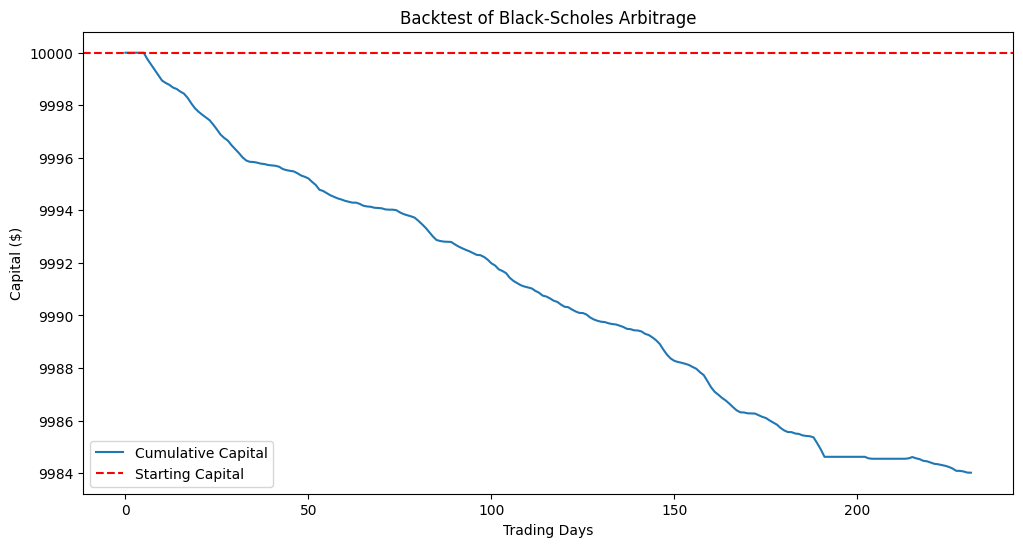

Total Return: $-15.98
Sharpe Ratio: -17.89
Maximum Drawdown: $-15.98


In [ ]:
from scipy.stats import norm
def black_scholes_arbitrage(S, K, T, sigma, r=0):
    """
    Black-Scholes for Arbitrage
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Call-like and Put-like probabilities
    call_prob = norm.cdf(d1)
    put_prob = norm.cdf(-d1)
    return call_prob, put_prob

# Simulated Spread Data
np.random.seed(42)
n = 252  # Number of trading days (1 year)
spread = np.cumsum(np.random.normal(0, 0.05, n))  # Simulated spread series
rolling_mean = pd.Series(spread).rolling(window=20).mean()  # Rolling mean
rolling_vol = pd.Series(spread).rolling(window=20).std()  # Rolling volatility
T = 1 / 252  # Daily time to expiry (1 day)

